In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# load the dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
eeg_data = pd.read_csv(file_path)

# preprocessing
# select only numerical columns
numerical_columns = eeg_data.select_dtypes(include=['float64', 'int64']).columns
eeg_numerical_data = eeg_data[numerical_columns]

# handle missing values
# drop columns with more than 50% missing values
threshold = 0.5 * len(eeg_numerical_data)
filtered_data = eeg_numerical_data.dropna(axis=1, thresh=threshold)

# fill remaining missing values with column means
preprocessed_data = filtered_data.fillna(filtered_data.mean())

# normalize the data to [0, 1] range
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(preprocessed_data)

# dimensionality reduction using PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(normalized_data)

# check reduced dimensionality
print(f"Reduced dimensionality: {pca_data.shape}")

# split the data
# split into train, validation, and test sets (80-10-10 split)
train_data, temp_data = train_test_split(pca_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# summarize the preprocessed data
print(f"Training data shape after PCA: {train_data.shape}")
print(f"Validation data shape after PCA: {val_data.shape}")
print(f"Test data shape after PCA: {test_data.shape}")

# convert to PyTorch Tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size)


Reduced dimensionality: (945, 87)
Training data shape after PCA: (756, 87)
Validation data shape after PCA: (94, 87)
Test data shape after PCA: (95, 87)


In [2]:
# define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# train the VAE
input_dim = pca_data.shape[1]
latent_dim = 16
vae = VAE(input_dim, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae.train()
num_epochs = 500
for epoch in range(num_epochs):
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

print("VAE training complete.")

Epoch 1, Loss: 52.5980
Epoch 2, Loss: 43.9160
Epoch 3, Loss: 35.7975
Epoch 4, Loss: 33.6693
Epoch 5, Loss: 33.2458
Epoch 6, Loss: 33.1548
Epoch 7, Loss: 33.1090
Epoch 8, Loss: 33.0664
Epoch 9, Loss: 33.0523
Epoch 10, Loss: 33.0086
Epoch 11, Loss: 33.0231
Epoch 12, Loss: 32.9973
Epoch 13, Loss: 32.9684
Epoch 14, Loss: 32.9221
Epoch 15, Loss: 32.8061
Epoch 16, Loss: 32.4218
Epoch 17, Loss: 32.1043
Epoch 18, Loss: 31.9845
Epoch 19, Loss: 31.8581
Epoch 20, Loss: 31.7668
Epoch 21, Loss: 31.7945
Epoch 22, Loss: 31.7738
Epoch 23, Loss: 31.7696
Epoch 24, Loss: 31.6979
Epoch 25, Loss: 31.7247
Epoch 26, Loss: 31.6321
Epoch 27, Loss: 31.8014
Epoch 28, Loss: 31.8659
Epoch 29, Loss: 31.6739
Epoch 30, Loss: 31.7173
Epoch 31, Loss: 31.6746
Epoch 32, Loss: 31.6897
Epoch 33, Loss: 31.7444
Epoch 34, Loss: 31.7316
Epoch 35, Loss: 31.8239
Epoch 36, Loss: 31.6427
Epoch 37, Loss: 31.6607
Epoch 38, Loss: 31.7289
Epoch 39, Loss: 31.6459
Epoch 40, Loss: 31.7275
Epoch 41, Loss: 31.5928
Epoch 42, Loss: 31.6423
E

In [3]:
# evaluate reconstruction metrics
def evaluate_reconstruction(model, dataloader):
    model.eval()
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            recon_x, _, _ = model(x)
            total_mse += nn.functional.mse_loss(recon_x, x, reduction='sum').item()
            total_mae += nn.functional.l1_loss(recon_x, x, reduction='sum').item()

    mse = total_mse / len(dataloader.dataset)
    mae = total_mae / len(dataloader.dataset)
    return mse, mae

# evaluate on the test set
test_mse, test_mae = evaluate_reconstruction(vae, test_loader)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test MSE: 34.3965
Test MAE: 28.4556


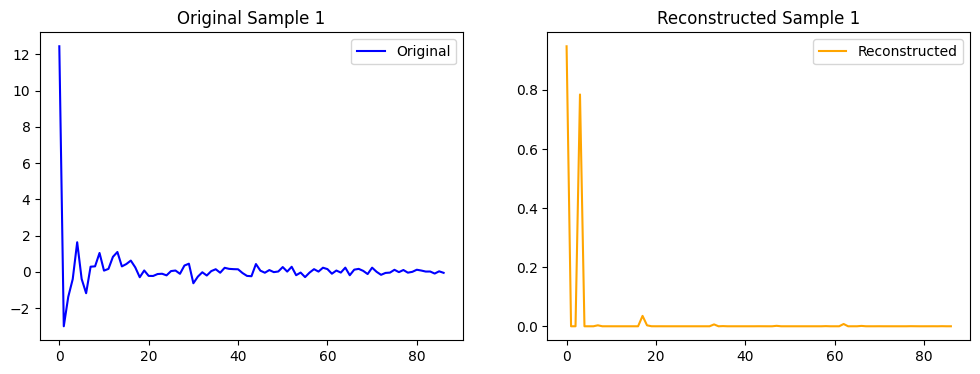

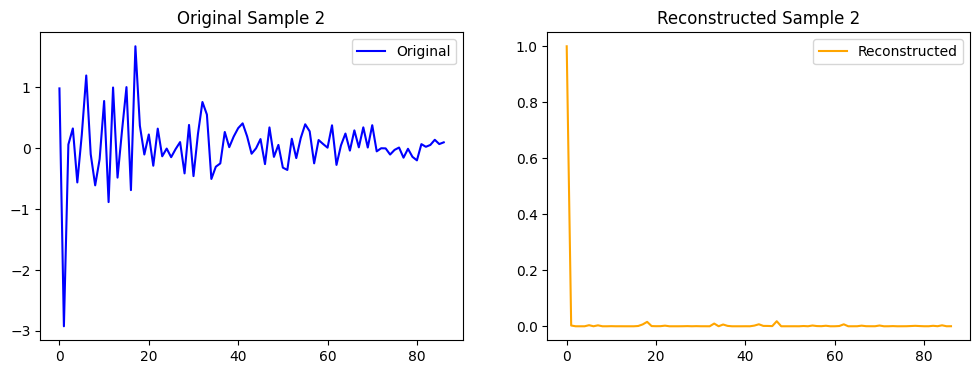

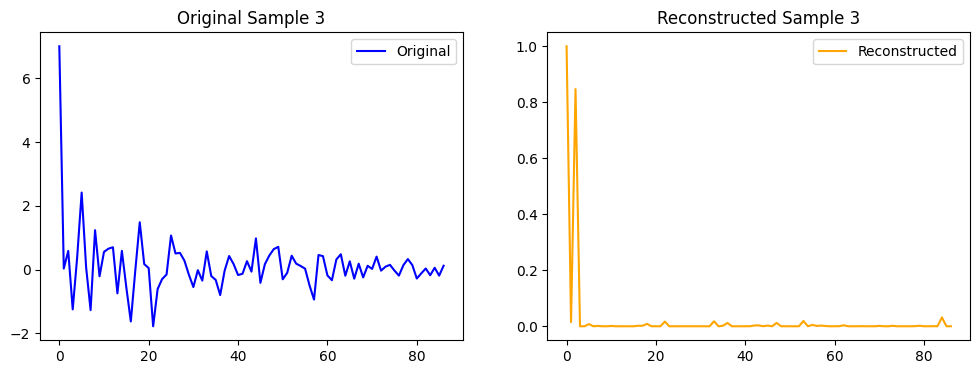

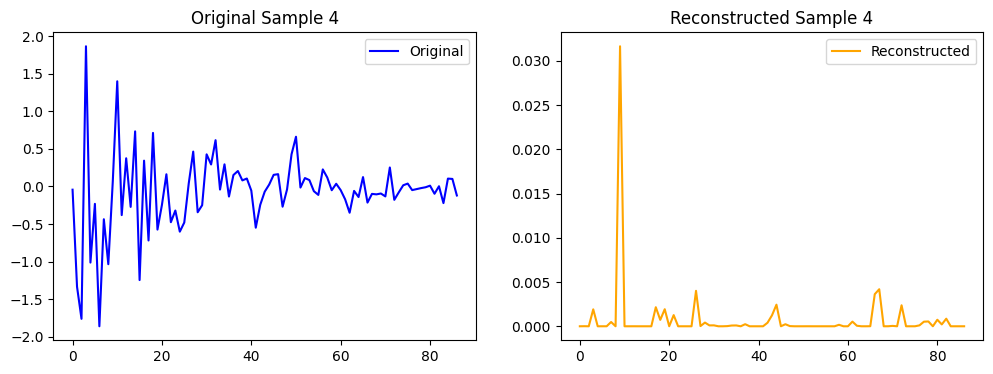

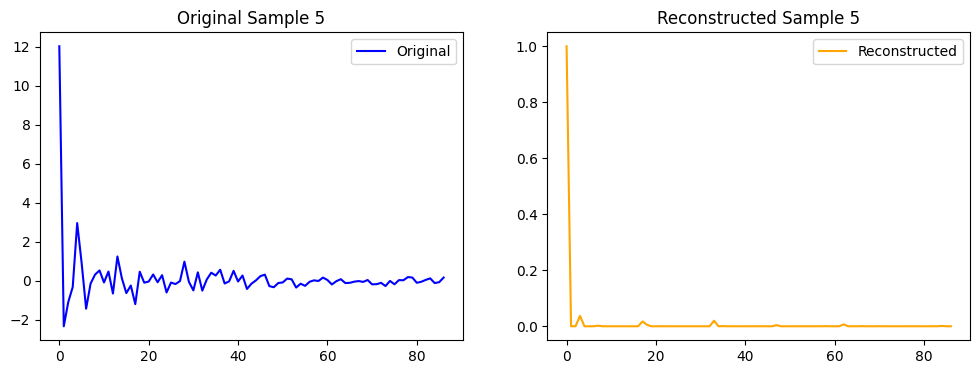

In [4]:

# visualize reconstruction results
def visualize_reconstruction(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            recon_x, _, _ = model(x)
            x = x.cpu().numpy()
            recon_x = recon_x.cpu().numpy()

            # plot original and reconstructed samples
            for i in range(min(num_samples, len(x))):
                plt.figure(figsize=(12, 4))

                # plot Original
                plt.subplot(1, 2, 1)
                plt.plot(x[i], label='Original', color='blue')  # Set color for Original
                plt.title(f"Original Sample {i+1}")
                plt.legend()

                # plot Reconstructed
                plt.subplot(1, 2, 2)
                plt.plot(recon_x[i], label='Reconstructed', color='orange')  # Set color for Reconstructed
                plt.title(f"Reconstructed Sample {i+1}")
                plt.legend()

                plt.show()
            break

# visualise reconstruction results on test data
visualize_reconstruction(vae, test_loader, num_samples=5)


In [5]:
# function to compute metrics
def compute_metrics_vae(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    all_original = []
    all_reconstructed = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            recon_x, mu, logvar = model(x)

            # compute losses
            recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            # store results
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            all_original.append(x.cpu().numpy())
            all_reconstructed.append(recon_x.cpu().numpy())

    # flatten arrays for metrics
    all_original = np.concatenate(all_original)
    all_reconstructed = np.concatenate(all_reconstructed)

    # compute additional metrics
    mae = np.mean(np.abs(all_original - all_reconstructed))
    r2 = 1 - np.sum((all_original - all_reconstructed)**2) / np.sum((all_original - np.mean(all_original))**2)

    return {
        "Total Loss": total_loss / len(data_loader.dataset),
        "Reconstruction Loss": total_recon_loss / len(data_loader.dataset),
        "KL Divergence": total_kl_loss / len(data_loader.dataset),
        "MAE": mae,
        "R²": r2
    }

metrics1 = compute_metrics_vae(vae, test_loader, device)
print(metrics1)


{'Total Loss': 35.30994487561678, 'Reconstruction Loss': 34.15736212479441, 'KL Divergence': 1.152581827264083, 'MAE': 0.3256639, 'R²': 0.10175448656082153}


In [6]:
import numpy as np

vae.eval()  # set the VAE to evaluation mode
latent_vectors = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)  # get the input data
        mu, _ = vae.encode(x)  # extract the mean of the latent distribution
        latent_vectors.append(mu.cpu().numpy())  # move to CPU and store

latent_vectors = np.concatenate(latent_vectors, axis=0)  # combine all batches


In [7]:
from sklearn.manifold import TSNE

# reduce to 2D for visualization
reduced_latents = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors)


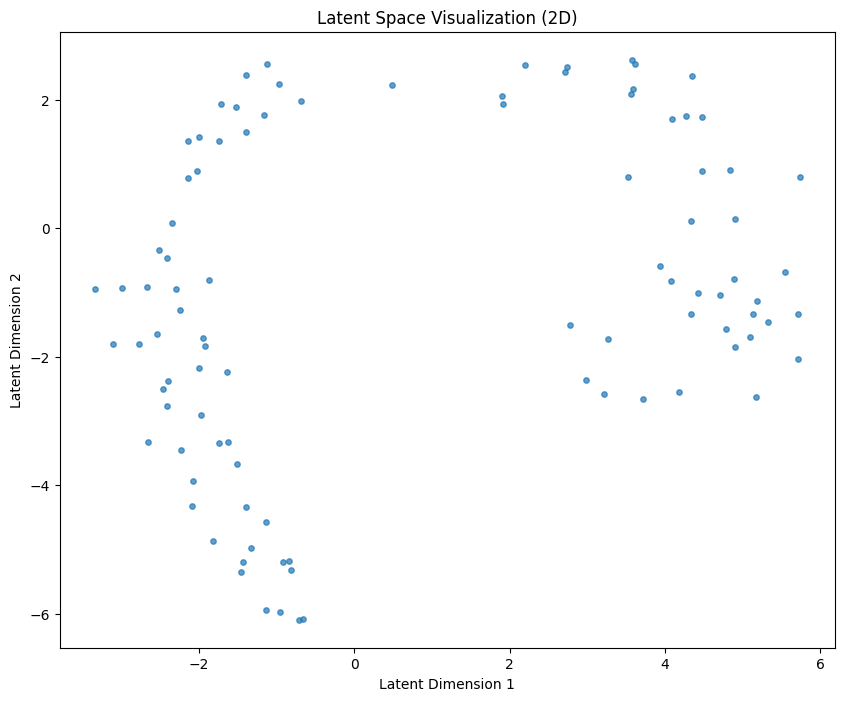

In [8]:
import matplotlib.pyplot as plt

# plot the 2D latent space
plt.figure(figsize=(10, 8))
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], alpha=0.7, s=15)
plt.title('Latent Space Visualization (2D)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(False)
plt.show()


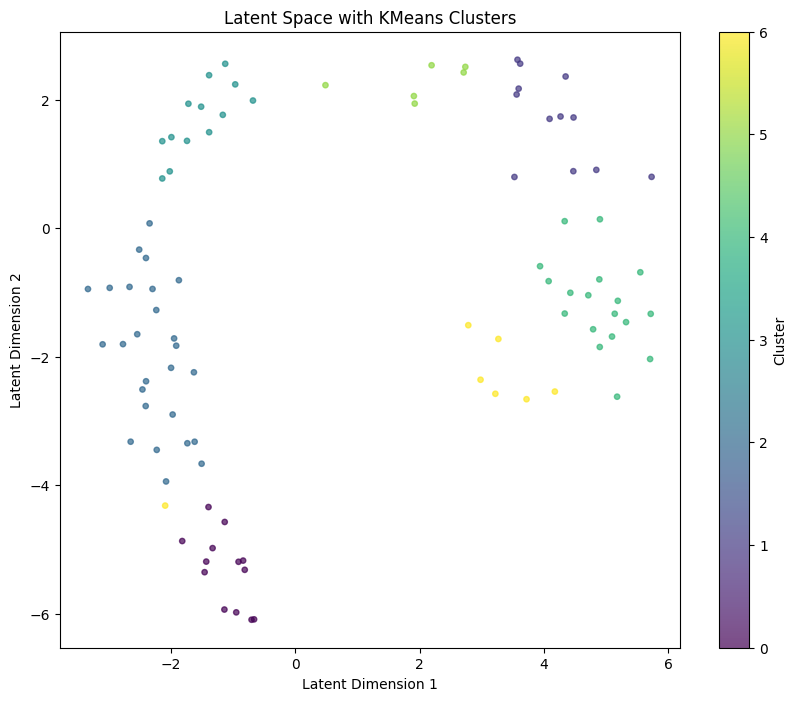

In [9]:
from sklearn.cluster import KMeans

# apply KMeans clustering to the latent space
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

# plot clustered latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=15)
plt.colorbar(scatter, label='Cluster')
plt.title('Latent Space with KMeans Clusters')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(False)
plt.show()


In [10]:
def extract_latent_space(vae, dataloader):
    vae.eval()
    latents = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            mu, logvar = vae.encode(x)
            z = vae.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy())
    return np.concatenate(latents, axis=0)


In [11]:
from sklearn.cluster import KMeans

def generate_pseudo_labels(latents, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    pseudo_labels = kmeans.fit_predict(latents)
    return pseudo_labels


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def compute_dci_metrics(latents, pseudo_labels):
    num_clusters = len(set(pseudo_labels))
    disentanglement_scores = []
    completeness_scores = []

    for cluster_id in range(num_clusters):
        cluster_labels = (pseudo_labels == cluster_id).astype(int)  # Binary labels for this cluster
        model = LogisticRegression(max_iter=1000)
        model.fit(latents, cluster_labels)
        predictions = model.predict(latents)

        # Informativeness: accuracy of the cluster prediction
        accuracy = accuracy_score(cluster_labels, predictions)

        # Disentanglement: how much a latent dimension captures this cluster
        importance = np.abs(model.coef_)  # Feature importances
        importance /= importance.sum(axis=1, keepdims=True)  # Normalize
        disentanglement = (importance**2).sum(axis=0).mean()

        # Completeness: how well all latent dimensions collectively explain the cluster
        completeness = 1.0 / np.var(importance, axis=1).mean()

        disentanglement_scores.append(disentanglement)
        completeness_scores.append(completeness)

    # Average metrics
    disentanglement = np.mean(disentanglement_scores)
    completeness = np.mean(completeness_scores)
    informativeness = accuracy  # Overall predictive power of the latent space

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness,
    }


In [13]:
# extract latent space
latents = extract_latent_space(vae, test_loader)

# generate pseudo-labels
num_clusters = 7
pseudo_labels = generate_pseudo_labels(latents, num_clusters)

# compute DCI metrics
dci_metrics = compute_dci_metrics(latents, pseudo_labels)

print("DCI Metrics (with pseudo-labels):")
print(f"Disentanglement: {dci_metrics['disentanglement']:.4f}")
print(f"Completeness: {dci_metrics['completeness']:.4f}")
print(f"Informativeness: {dci_metrics['informativeness']:.4f}")


DCI Metrics (with pseudo-labels):
Disentanglement: 0.0055
Completeness: 729.8905
Informativeness: 1.0000
